# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import copy

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


In [4]:
df[df['Customer ID'] == 7]

,Customer ID,Date,Subtotal,Country
11103,7,12/9/2012,0.40,Czech Republic
11931,7,3/13/2013,1.86,Czech Republic
19164,7,2/11/2015,13.28,Czech Republic


Převedení dat do RFM pomocí groupby a agregačních funkcí

In [5]:
rfm = df.groupby('Customer ID').agg({
    'Date': lambda a: pd.to_datetime(pd.Series(['12/19/2015'])) - max(pd.to_datetime(a)),
    'Customer ID': 'count',
    'Subtotal': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary'] 

In [6]:
delta_days = []
for date in rfm['Recency']:
    delta_days.append(date.days)
rfm['Recency'] = delta_days

In [32]:
rfm.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
7,311,3,15.54,0
9,3050,1,13.20,1
30,3025,1,36.20,1
34,3103,1,86.00,1
38,3097,1,38.40,1


In [8]:
rfm.describe()

,Recency,Frequency,Monetary
count,12829.000000,12829.000000,12829.000000
mean,1102.619690,1.746668,155.806657
std,726.546225,2.010044,407.744435
min,0.000000,1.000000,1.180000
25%,456.000000,1.000000,32.040000
50%,1062.000000,1.000000,64.810000
75%,1681.000000,2.000000,143.510000
max,3103.000000,45.000000,21392.380000


Data je nutné normalizovat, protože se hodnoty jednotlivých sloupců řádově liší (v průměrných hodnotách až o 3 řády) 

In [9]:
scaler = StandardScaler()
scaler.fit(rfm)
rfm_normalized = scaler.transform(rfm)

In [10]:
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized.describe()

,0,1,2
count,1.282900e+04,1.282900e+04,1.282900e+04
mean,-1.099856e-15,3.361036e-15,-1.125995e-17
std,1.000039e+00,1.000039e+00,1.000039e+00
min,-1.517677e+00,-3.714828e-01,-3.792392e-01
25%,-8.900258e-01,-3.714828e-01,-3.035516e-01
50%,-5.591010e-02,-3.714828e-01,-2.231795e-01
75%,7.960992e-01,1.260381e-01,-3.015893e-02
max,2.753381e+00,2.151944e+01,5.208508e+01


In [11]:
def k_means(data): 
    '''provede 10 krát algoritmus k-means a zobrazí tabulku s hodnotami a graf'''
    ix = np.zeros(10)
    iy = np.zeros(ix.shape[0])
    modifier = 2 # slouží k tomu, aby k-means začínal na 2 clusterech (podle zadání jsou nutné alespoň 3 clustery)
    for k in range(ix.shape[0]):
        kmeans = KMeans(n_clusters=k+modifier, random_state = 1)
        kmeans.fit(data)
        iy[k] = kmeans.inertia_
        ix[k] = k+modifier

    diff = [np.nan]
    for k in range(1, ix.shape[0]):
        diff.append(iy[k - 1] - iy[k])
    data = {'Clusters': ix, 'Inertia_': iy, 'Difference': diff}
    table = pd.DataFrame(data)

    plt.xlabel('$k$')
    plt.ylabel('Objective function')
    plt.plot(ix, iy, 'o-')
    plt.show()
    display(table)

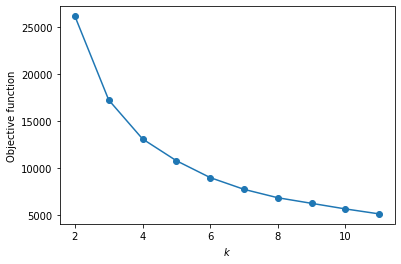

,Clusters,Inertia_,Difference
0,2.0,26187.611939,NaN
1,3.0,17276.318511,8911.293427
2,4.0,13136.843282,4139.475230
3,5.0,10820.352782,2316.490500
4,6.0,9024.192941,1796.159841
5,7.0,7775.042599,1249.150342
6,8.0,6880.572151,894.470448
7,9.0,6284.858894,595.713258
8,10.0,5690.642547,594.216346
9,11.0,5160.894854,529.747694


In [12]:
k_means(rfm_normalized)

Z tabulky a grafu jsem jako nejvýhodnější počet clusterů odhadnul 5 a 6, po vyzkoušení obou jsem usoudil, že 5 clusterů je výhodnějších, protože při více clusterech mi začal algoritmus dělit nezajímavé skupiny zákazníků. 

In [13]:
kmeans = KMeans(n_clusters=5, random_state = 1)
kmeans.fit(rfm_normalized)
rfm['Cluster'] = kmeans.labels_

In [14]:
# funguje pouze od pandas verze 25.0 (pro nižší verze viz níže)
rfm.groupby('Cluster').agg(
    Recency=pd.NamedAgg(column='Recency', aggfunc=np.mean),
    Frequency=pd.NamedAgg(column='Frequency', aggfunc=np.mean),
    Monetary=pd.NamedAgg(column='Monetary', aggfunc=np.mean),
    Count=pd.NamedAgg(column='Recency', aggfunc=np.size)
)

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,572.954084,1.329145,97.487358,6207
1,1804.730274,1.239434,83.274535,5513
2,615.404915,5.321581,570.247553,936
3,500.333333,15.133333,7767.627333,15
4,355.569620,13.398734,1799.879367,158


Výsledné clustery: 
- nejzajímavější skupina je skupina 3, jedná se o skupina, která nakupovala poměrně nedávno, nakupuje často a závoveň utrácela velké množství peněz
- podovně zajímavou skupinou je cluster 4, má víceméně stejné parametry, liší se výrazně pouze v částce utrácení 
- 3. nejzajímavější skupinou je cluster 2, tito zákazníci nakupovali ještě poměrně nedávno, vícekrát než jednou a utráceli ještě poměrně slušné množství peněz v průměru (tato skupina je také daleko početnější než skupiny předchozí)
- poslední dva clustery (0 a 1) jsou víceméně nezajímavý zákazníci, nenakupovali nedávno, většinou nakupovali pouze jednou a ani neutráceli moc peněz => jedná se o nezajímavé zákazníky

### Bonus
Zkuste provést to samé s modifikovanou verzí RFM, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

In [15]:
# přepočet data, aby se s ním lépe pracovalo v bonusových úlohách
appropriate_rows = []
in_last_year = []
for row in df.iterrows():
    if pd.to_datetime(row[1]["Date"]) > pd.to_datetime('12/19/2014'):
        appropriate_rows.append(pd.Series(row[0]))
        in_last_year.append(1)
    else:
        in_last_year.append(0)

In [16]:
df_bonus = copy.deepcopy(df)
df_bonus['In_last_year'] = in_last_year
df_bonus

,Customer ID,Date,Subtotal,Country,In_last_year
0,34,6/21/2007,86.00,Czech Republic,0
1,38,6/27/2007,38.40,Czech Republic,0
2,47,7/2/2007,53.50,Slovakia,0
3,61,7/14/2007,7.00,Czech Republic,0
4,78,7/21/2007,55.50,Czech Republic,0
...,...,...,...,...,...
22403,15356,12/18/2015,31.87,Czech Republic,1
22404,15357,12/18/2015,6.10,Czech Republic,1
22405,15358,12/18/2015,153.23,Czech Republic,1
22406,15359,12/19/2015,19.15,Czech Republic,1


In [17]:
# převedení do upraveného RFM
rfm_bonus = df_bonus.groupby('Customer ID').agg({
    'Date': lambda a: pd.to_datetime(pd.Series(['12/19/2015'])) - max(pd.to_datetime(a)),
    'In_last_year': 'count',
    'Subtotal': 'max'
})
rfm_bonus.columns = ['Recency', 'Frequency', 'Monetary'] 

In [18]:
# přepočet Recency
delta_months = []
for date in rfm_bonus['Recency']:
    delta_months.append(max(date.days//30, 1))
rfm_bonus['Recency'] = delta_months

In [44]:
rfm_bonus['Recency']

Customer ID
7         10
9        101
30       100
34       103
38       103
        ... 
15356      1
15357      1
15358      1
15359      1
15360      1
Name: Recency, Length: 12829, dtype: int64

In [45]:
# přepočet Frequency
frequency = []
for k in rfm_bonus['Frequency']:
    frequency.append(max(k, 1))
rfm_bonus['Frequency'] = frequency

In [20]:
rfm_bonus

,Recency,Frequency,Monetary
Customer ID,,,
7,10,3,13.28
9,101,1,13.20
30,100,1,36.20
34,103,1,86.00
38,103,1,38.40
...,...,...,...
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23


Důvod škálování je stejný jako v základní částo úkolu

In [21]:
scaler_bonus = StandardScaler()
scaler_bonus.fit(rfm_bonus)
rfm_bonus_normalized = scaler_bonus.transform(rfm_bonus)

In [22]:
rfm_bonus_normalized = pd.DataFrame(rfm_bonus_normalized)
rfm_bonus_normalized.describe()

,0,1,2
count,1.282900e+04,1.282900e+04,1.282900e+04
mean,-1.792523e-15,3.361036e-15,1.853473e-17
std,1.000039e+00,1.000039e+00,1.000039e+00
min,-1.459267e+00,-3.714828e-01,-3.815392e-01
25%,-8.805006e-01,-3.714828e-01,-2.622749e-01
50%,-5.369197e-02,-3.714828e-01,-1.559008e-01
75%,8.144571e-01,1.260381e-01,5.705079e-02
max,2.757457e+00,2.151944e+01,8.501001e+01


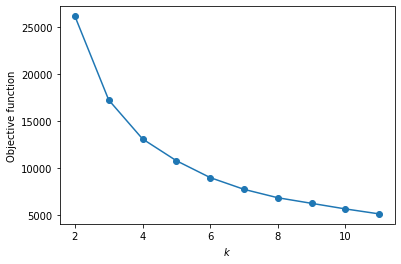

,Clusters,Inertia_,Difference
0,2.0,26187.611939,NaN
1,3.0,17276.318511,8911.293427
2,4.0,13136.843282,4139.475230
3,5.0,10820.352782,2316.490500
4,6.0,9024.192941,1796.159841
5,7.0,7775.042599,1249.150342
6,8.0,6880.572151,894.470448
7,9.0,6284.858894,595.713258
8,10.0,5690.642547,594.216346
9,11.0,5160.894854,529.747694


In [23]:
# využití předchozích dat (klasického RFM) -> zobrazeno k porovnání s bonusem
k_means(rfm_normalized)

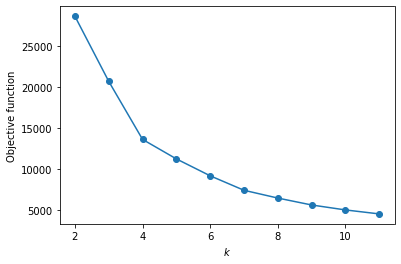

,Clusters,Inertia_,Difference
0,2.0,28584.711756,NaN
1,3.0,20657.272100,7927.439656
2,4.0,13590.262378,7067.009722
3,5.0,11217.663064,2372.599314
4,6.0,9159.136018,2058.527046
5,7.0,7396.551927,1762.584091
6,8.0,6449.801259,946.750668
7,9.0,5607.607446,842.193813
8,10.0,5005.035835,602.571611
9,11.0,4520.371428,484.664407


In [24]:
# statistiky bonusu
k_means(rfm_bonus_normalized) 

Podle výsledků bych vybral v tomto případě 4 clustery, protože je tam vidět jakýsi "loket"

In [27]:
kmeans = KMeans(n_clusters=4, random_state = 1)
kmeans.fit(rfm_bonus_normalized)
result1 = rfm_bonus
result1['Cluster'] = kmeans.labels_

In [28]:
# funguje pouze od pandas verze 25.0 (pro nižší verze viz níže)
result1.groupby('Cluster').agg(
    Recency=pd.NamedAgg(column='Recency', aggfunc=np.mean),
    Frequency=pd.NamedAgg(column='Frequency', aggfunc=np.mean),
    Monetary=pd.NamedAgg(column='Monetary', aggfunc=np.mean),
    Count=pd.NamedAgg(column='Recency', aggfunc=np.size)
)

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,59.401912,1.291431,73.111454,5648
1,15.115163,9.437620,314.208733,521
2,34.000000,5.000000,21001.050000,1
3,18.361015,1.530560,93.293832,6659


Jak je vidět z tabulky, mám sice 4 clustery, avšak v jednom clusteru mám pouze jednoho zákazníka, proto pro  lepší clusterování přidám jeden cluster navíc

In [42]:
kmeans = KMeans(n_clusters=5, random_state = 1)
kmeans.fit(rfm_bonus_normalized)
result2 = rfm_bonus
result2['Cluster'] = kmeans.labels_

In [43]:
# funguje pouze od pandas verze 25.0 (pro nižší verze viz níže)
result2.groupby('Cluster').agg(
    Recency=pd.NamedAgg(column='Recency', aggfunc=np.mean),
    Frequency=pd.NamedAgg(column='Frequency', aggfunc=np.mean),
    Monetary=pd.NamedAgg(column='Monetary', aggfunc=np.mean),
    Count=pd.NamedAgg(column='Recency', aggfunc=np.size)
)

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,18.373593,1.531733,93.714612,6665
1,59.412578,1.291408,73.050138,5645
2,34.000000,5.000000,21001.050000,1
3,15.070039,9.505837,264.418171,514
4,13.250000,4.500000,6248.252500,4


- Cluster 0 - jedná se o poměrně nezajímavé zákazníky, malá Monetary a malá Frequency
- Cluster 1 - jedná se o naprosto nezajímavé zákazníky
- Cluster 2 - je zde pouze jeden zákazník, který už poměrně dlouho nenakupoval, i přes to že utratil hodně penez, je nezajímavý
- Cluster 3 - 